In [ ]:
!pip install neuroHarmonize neuroCombat

In [ ]:
# Imports
# Visualize
import matplotlib.pyplot as plt
# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from neuroHarmonize import harmonizationLearn, harmonizationApply
# Fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.kernel_ridge import KernelRidge

In [ ]:
import kagglehub
import os
# Download latest version
BASE_PATH = kagglehub.dataset_download("kingpowa/preprocessed-ixi-dataset-with-fs8")
BASE_PATH_IXI = os.path.join(BASE_PATH, "T1w_Processed_IXI_with_csv", "IXI")
BASE_PATH_EXE = os.path.join(BASE_PATH, "example_data")

Now we will try to predict the brain age based on the EDA we did before. Let's start by visualizing the cortical thicknesses relations with the age

In [ ]:
# We will use this as our demogprahic dataset
masterfile_path = f"{BASE_PATH_IXI}/subjects.csv"
masterfile = pd.read_csv(masterfile_path)
masterfile = masterfile[masterfile["age"] != -1.0]
masterfile.head(5)

,subject_id,age,sex,scanner,site,diagnosis,dataset_name,subject_key,session,run,registered_mni
0,IXI002,35.80,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,IXI002_IXI,1,1,sub-IXI002/ses-1/run-1/anat/sub-IXI002_acq-Phi...
1,IXI012,38.78,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI012_IXI,1,1,sub-IXI012/ses-1/run-1/anat/sub-IXI012_acq-Phi...
2,IXI013,46.71,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI013_IXI,1,1,sub-IXI013/ses-1/run-1/anat/sub-IXI013_acq-Phi...
3,IXI014,34.24,Female,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI014_IXI,1,1,sub-IXI014/ses-1/run-1/anat/sub-IXI014_acq-Phi...
4,IXI015,24.28,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,IXI015_IXI,1,1,sub-IXI015/ses-1/run-1/anat/sub-IXI015_acq-Phi...


In [ ]:
thickness_df = pd.read_csv(f"{BASE_PATH_IXI}/thickness.csv")
thickness_df

,subject_id,hemi,region,mean_thickness_weighted,mean_thickness_simple,n_vertices,total_area
0,IXI002,lh,unknown,0.000369,0.000338,8853,5502.432653
1,IXI002,lh,caudalanteriorcingulate,2.767575,2.609781,1437,1083.926104
2,IXI002,lh,caudalmiddlefrontal,2.828643,2.690581,3830,2769.405243
3,IXI002,lh,cuneus,2.019888,2.020947,2739,2037.500121
4,IXI002,lh,entorhinal,2.712761,2.636525,708,687.427367
...,...,...,...,...,...,...,...
37063,IXI662,rh,superiorparietal,2.120859,2.023058,6653,5314.046982
37064,IXI662,rh,superiortemporal,2.965944,2.796967,8804,7119.010455
37065,IXI662,rh,supramarginal,2.508402,2.370133,5606,4399.206890
37066,IXI662,rh,transversetemporal,2.354042,2.350365,628,446.668808


Let's see how the thickness values changes based on the age.

Exercise:

Write a function to handle the thickness dataset with the provided demographic values from the `subjects.csv` file. Afterwards, visualize the effect of corthical thickness values based on the `caudalanteriorcingulate, rh` value and the `transversetemporal, lh`. What do you notice?
Write the pandas dataframe as "merged"

Let's use a simple regression to try to predict the brain age. First, let's divide our dataset in useful groups.

In [7]:
# Let's extract the per thickness matrix
def make_thickness_matrix(df,
                          sample_id_cols=['subject_id', 'session', 'run'],
                          metadata_cols=['age', 'sex', 'scanner', 'site', 'diagnosis', 'dataset_name'],
                          value_col='mean_thickness_weighted',
                          hemi_col='hemi',
                          region_col='region',
                          aggfunc='mean'):
    df = df.copy()
    df['sample_id'] = df[sample_id_cols].astype(str).agg('_'.join, axis=1)

    # pivoting
    index_cols = ['sample_id'] + list(sample_id_cols) + list(metadata_cols)
    pivot = df.pivot_table(
        index=index_cols,
        columns=[hemi_col, region_col],
        values=value_col,
        aggfunc=aggfunc  # if duplicates exist (e.g., multiple entries), aggregate
    )

    pivot.columns = [f"{hemi}_{region}" for hemi, region in sorted(pivot.columns)]
    wide_df = pivot.reset_index()

    return wide_df

Before creating the thickness matrix, let's make sure that the thickness is well defined for all the regions

In [8]:
merged['sample_id'] = merged[['subject_id', 'session', 'run']].astype(str).agg('_'.join, axis=1)
coverage = (merged
            .drop_duplicates(subset=['sample_id', 'hemi', 'region'])
            .groupby(['hemi', 'region'])['sample_id']
            .nunique()
            .sort_values(ascending=True))
print(coverage)

hemi  region                 
rh    temporalpole                 2
lh    caudalanteriorcingulate    560
rh    cuneus                     560
      entorhinal                 560
      fusiform                   560
                                ... 
lh    superiorparietal           560
      superiortemporal           560
      supramarginal              560
      unknown                    560
rh    unknown                    560
Name: sample_id, Length: 65, dtype: int64


As you can see, we have only 2 samples with temporalpole rh region. Let's investigate why

In [ ]:
thickness_matrix_df = make_thickness_matrix(
    df=merged,
    value_col='mean_thickness_weighted'
)

# Given this matrix and the dataset you got before can you guess what is the problem?
# Call the final matrix "proper_thickness_matrix_df"

Exercise:

You have the matrix "merged" from the previous exercise which blends demographics + thickness information.
You have two samples with temporalpole rh region.
Study the problem, identify it, and solve it by creating a final `proper_thickness_matrix_df`.

In [ ]:
proper_thickness_matrix_df = None

Let's define the datasets

In [14]:
test_set = proper_thickness_matrix_df[proper_thickness_matrix_df["scanner"] == "GE-1.5T"]
train_set = proper_thickness_matrix_df[proper_thickness_matrix_df["scanner"] != "GE-1.5T"]

test_set["subject_id"].nunique(), train_set["subject_id"].nunique()

(66, 494)

Exercise:

Write a function to handle the thickness dataset with the provided demographic values from the `subjects.csv` file. Afterwards, visualize the effect of corthical thickness values based on the `caudalanteriorcingulate, rh` value and the `transversetemporal, lh`. What do you notice?
Write the pandas dataframe as "merged"

In [15]:
train_set.columns

Index(['sample_id', 'subject_id', 'session', 'run', 'age', 'sex', 'scanner',
       'site', 'diagnosis', 'dataset_name', 'lh_caudalanteriorcingulate',
       'lh_caudalmiddlefrontal', 'lh_cuneus', 'lh_entorhinal', 'lh_fusiform',
       'lh_inferiorparietal', 'lh_inferiortemporal', 'lh_insula',
       'lh_isthmuscingulate', 'lh_lateraloccipital', 'lh_lateralorbitofrontal',
       'lh_lingual', 'lh_medialorbitofrontal', 'lh_middletemporal',
       'lh_paracentral', 'lh_parahippocampal', 'lh_parsopercularis',
       'lh_parsorbitalis', 'lh_parstriangularis', 'lh_pericalcarine',
       'lh_postcentral', 'lh_posteriorcingulate', 'lh_precentral',
       'lh_precuneus', 'lh_rostralanteriorcingulate',
       'lh_rostralmiddlefrontal', 'lh_superiorfrontal', 'lh_superiorparietal',
       'lh_superiortemporal', 'lh_supramarginal', 'lh_transversetemporal',
       'rh_caudalanteriorcingulate', 'rh_caudalmiddlefrontal', 'rh_cuneus',
       'rh_entorhinal', 'rh_fusiform', 'rh_inferiorparietal',
     

In [16]:
labels_features = [c for c in train_set.columns if "lh" in c or "rh" in c]
labels_features[:5]

['lh_caudalanteriorcingulate',
 'lh_caudalmiddlefrontal',
 'lh_cuneus',
 'lh_entorhinal',
 'lh_fusiform']

In [17]:
# Define features
X = train_set[labels_features].values  # start with one raw thickness measure
y = train_set['age'].values

# Validation of about ~20%
indices = np.arange(len(train_set))
tr_idx, te_idx = train_test_split(indices, test_size=0.2, random_state=0)

X_tr = X[tr_idx]
X_te = X[te_idx]
y_tr = y[tr_idx]
y_te = y[te_idx]

In [18]:
# Let's fit a linear regression without many problems.
model = LinearRegression()
model.fit(X_tr, y_tr)
y_pred = model.predict(X_te)

In [19]:
def mae_fn(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    return abs_errors.mean(), abs_errors.std()

Naive linear regression MAE: 9.952 +/- 6.614, R²: 0.497
Mean brain age gap (pred − true): 0.175


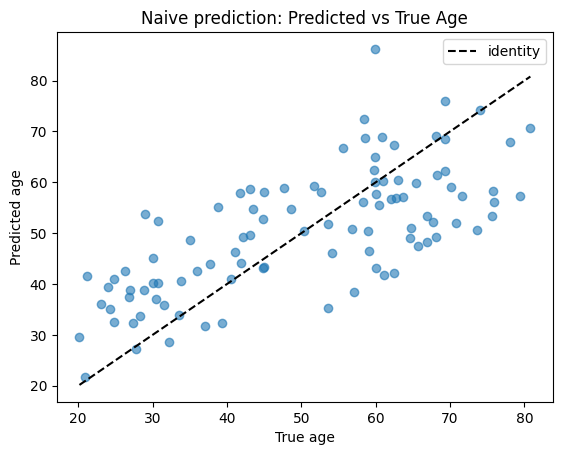

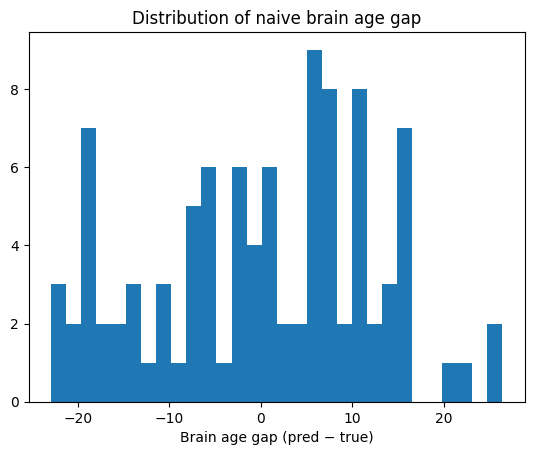

In [20]:
# And evaluate.
mae_m, mae_std = mae_fn(y_te.reshape(-1,1), y_pred.reshape(-1,1)) # Why mae? :)
r2 = r2_score(y_te, y_pred)
print(f"Naive linear regression MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

# Brain age gap
gap = y_pred - y_te
print(f"Mean brain age gap (pred − true): {np.mean(gap):.3f}")

# Plot
plt.figure()
plt.scatter(y_te, y_pred, alpha=0.6)
plt.plot([y_te.min(), y_te.max()],
         [y_te.min(), y_te.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title("Naive prediction: Predicted vs True Age")
plt.legend()
plt.show()

plt.figure()
plt.hist(gap, bins=30)
plt.xlabel("Brain age gap (pred − true)")
plt.title("Distribution of naive brain age gap")
plt.show()

It seems we got a fairly good model: R2 is good, MAE is a bit high. Can we guess why?
Let's change a bit the setting: we use this result to build an auxiliary model to predict age gap

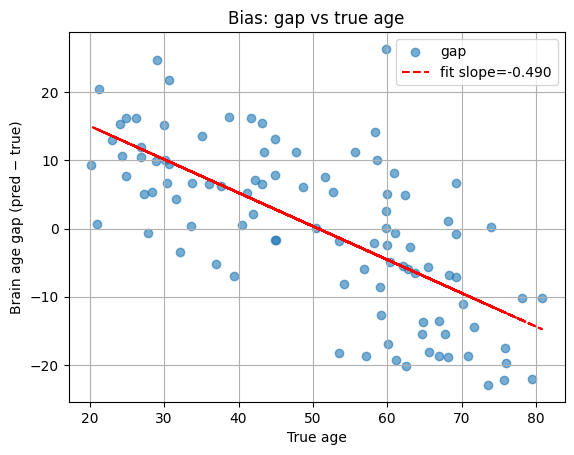

In [21]:
bias_model = LinearRegression().fit(y_te.reshape(-1,1), gap) # <- note, we are using the real age, which in theory we don't have access to!
predicted_gap = bias_model.predict(y_te.reshape(-1,1))

plt.figure()
plt.scatter(y_te, gap, alpha=0.6, label='gap')
plt.plot(y_te, predicted_gap, 'r--', label=f'fit slope={bias_model.coef_[0]:.3f}')
plt.xlabel("True age")
plt.ylabel("Brain age gap (pred − true)")
plt.title("Bias: gap vs true age")
plt.legend()
plt.grid(True)
plt.show()

What is this telling us? :)

Let's take into considerations the subject with the highest error

In [22]:
errors = np.abs(y_pred - y_te)
idx_sorted = np.argsort(-errors)  # descending
topk = 5
for i in idx_sorted[:topk]:
    print(f"Sample {i}: true age={y_te[i]:.1f}, pred={y_pred[i]:.1f}, error={errors[i]:.2f}")

Sample 72: true age=59.9, pred=86.2, error=26.35
Sample 43: true age=29.0, pred=53.8, error=24.79
Sample 39: true age=73.6, pred=50.6, error=22.93
Sample 47: true age=75.6, pred=53.4, error=22.22
Sample 82: true age=79.4, pred=57.3, error=22.07


In [23]:
train_set.iloc[te_idx[idx_sorted[:topk]]]

,sample_id,subject_id,session,run,age,sex,scanner,site,diagnosis,dataset_name,...,rh_posteriorcingulate,rh_precentral,rh_precuneus,rh_rostralanteriorcingulate,rh_rostralmiddlefrontal,rh_superiorfrontal,rh_superiorparietal,rh_superiortemporal,rh_supramarginal,rh_transversetemporal
359,IXI417_1_1,IXI417,1,1,59.88,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.379771,2.150974,2.134901,2.504101,2.196837,2.442319,2.169522,2.804760,2.282834,2.549284
114,IXI135_1_1,IXI135,1,1,29.00,Male,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.706621,2.559589,2.392805,2.867407,2.487334,2.726078,2.289662,2.815380,2.597338,2.681163
284,IXI327_1_1,IXI327,1,1,73.56,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.341492,2.596301,2.233497,2.676799,2.371612,2.574451,2.195186,3.026949,2.687759,2.249851
133,IXI158_1_1,IXI158,1,1,75.63,Female,Philips-1.5T,Guy’s-Hospital,Healthy,IXI,...,2.297943,2.225371,2.342985,2.701188,2.425102,2.618560,2.128800,3.063336,2.544517,2.578491
388,IXI448_1_1,IXI448,1,1,79.41,Male,Philips-3.0T,Hammersmith-Hospital,Healthy,IXI,...,2.618786,2.296445,2.160813,2.740014,2.572247,2.639678,2.139952,2.752182,2.401460,1.971724


In practice, our model is naively converging to the mean prediction, as we are doing an high error on the tail of the distribution. We can confirm this behaviour on the test set.

In [24]:
X_test_set = test_set[labels_features].values
y_test_set = test_set["age"].values

In [25]:
whole_model = LinearRegression()
whole_model.fit(X, y) # Both train, val
y_test_pred = whole_model.predict(X_test_set)

Naive linear regression MAE (Test Set): 13.375 +/- 8.779, R²: 0.001
Mean brain age gap (pred − true): 9.916


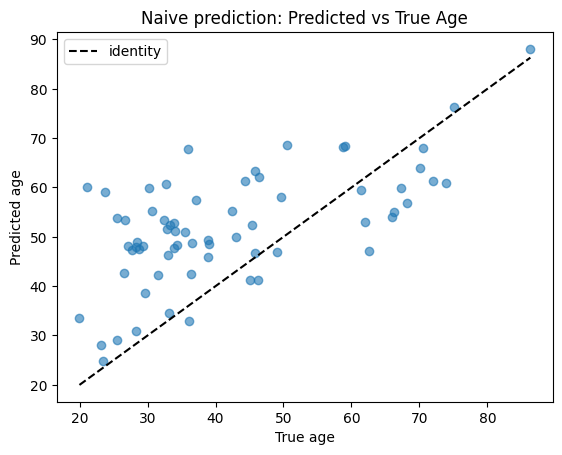

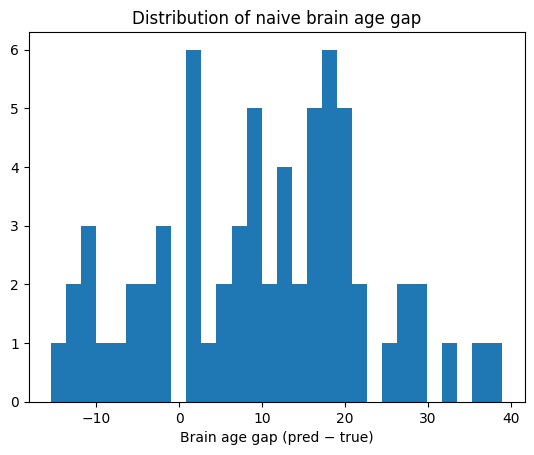

In [26]:
# And evaluate.
mae_m, mae_std = mae_fn(y_test_set.reshape(-1,1), y_test_pred.reshape(-1,1)) # Why mae? :)
r2 = r2_score(y_test_set, y_test_pred)
print(f"Naive linear regression MAE (Test Set): {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

# Brain age gap
gap = y_test_pred - y_test_set
print(f"Mean brain age gap (pred − true): {np.mean(gap):.3f}")

# Plot
plt.figure()
plt.scatter(y_test_set, y_test_pred, alpha=0.6)
plt.plot([y_test_set.min(), y_test_set.max()],
         [y_test_set.min(), y_test_set.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title("Naive prediction: Predicted vs True Age")
plt.legend()
plt.show()

plt.figure()
plt.hist(gap, bins=30)
plt.xlabel("Brain age gap (pred − true)")
plt.title("Distribution of naive brain age gap")
plt.show()

All the young sample we have are completely wrong :(

Can we improve?

The first step is to correct our prediction based on the fitted bias. Basically, we try to guess which is the "mean" value our prediction are being offsetted by.

In [ ]:
# Prediction on the validation set are corrected based on the predicted gap
y_pred_corrected = y_pred - predicted_gap # <- we got it before from the "bias" model

# Evaluate after correction
mae_corr_m, mae_corr_std = mae_fn(y_te, y_pred_corrected)
r2_corr = r2_score(y_te, y_pred_corrected)
print(f"After bias correction MAE: {mae_corr_m:.3f} +/- {mae_corr_std:.3f}, R²: {r2_corr:.3f}")

# Plot corrected vs true
plt.figure()
plt.scatter(y_te, y_pred_corrected, alpha=0.6, label="corrected")
plt.plot([y_te.min(), y_te.max()],
         [y_te.min(), y_te.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Corrected predicted age")
plt.title("Bias-corrected prediction")
plt.legend()
plt.show()

NameError: name 'y_pred' is not defined

This is extremely good... but you see an error?
Let's do this in the proper way

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=0) # <- We use only the train set!
oof_pred = np.zeros_like(y_tr)
for train_idx, val_idx in kf.split(X_tr):
    model_cv = LinearRegression()
    model_cv.fit(X_tr[train_idx], y_tr[train_idx])
    # We set the prediction based on the fold preformances 
    oof_pred[val_idx] = model_cv.predict(X_tr[val_idx])

gap_oof = oof_pred - y_tr
bias_model_oof = LinearRegression().fit(oof_pred.reshape(-1,1), gap_oof)

In [29]:
# Predict the expected bias from the predicted age
predicted_gap_corrected = bias_model_oof.predict(y_pred.reshape(-1,1))
# Corrected age
y_pred_corrected_no_leak = y_pred - predicted_gap_corrected

After bias correction MAE: 10.337 +/- 6.375, R²: 0.481


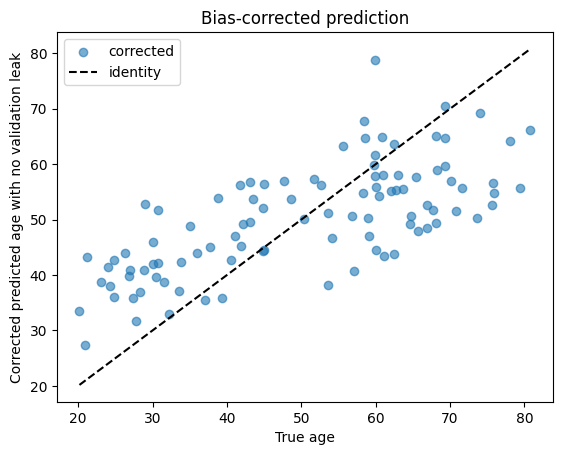

In [30]:
# Evaluate after correction
mae_corr_m, mae_corr_std = mae_fn(y_te, y_pred_corrected_no_leak)
r2_corr = r2_score(y_te, y_pred_corrected_no_leak)
print(f"After bias correction MAE: {mae_corr_m:.3f} +/- {mae_corr_std:.3f}, R²: {r2_corr:.3f}")

# Plot corrected vs true
plt.figure()
plt.scatter(y_te, y_pred_corrected_no_leak, alpha=0.6, label="corrected")
plt.plot([y_te.min(), y_te.max()],
         [y_te.min(), y_te.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Corrected predicted age with no validation leak")
plt.title("Bias-corrected prediction")
plt.legend()
plt.show()

Interestingly, when we fit the model with the correction we got a worse outcome! Why?

Let's investigate by visualizing the new bias prediction

In [31]:
pred_gap = bias_model_oof.predict(oof_pred.reshape(-1,1))
print("Bias model R²:", r2_score(gap_oof, pred_gap))

Bias model R²: 0.043380397831981554


Basically our model R2 is very low... it's most likely we are fitting noise. So this age prediction correction is not really working in our favour here. 
Maybe there is no age correction we can apply?

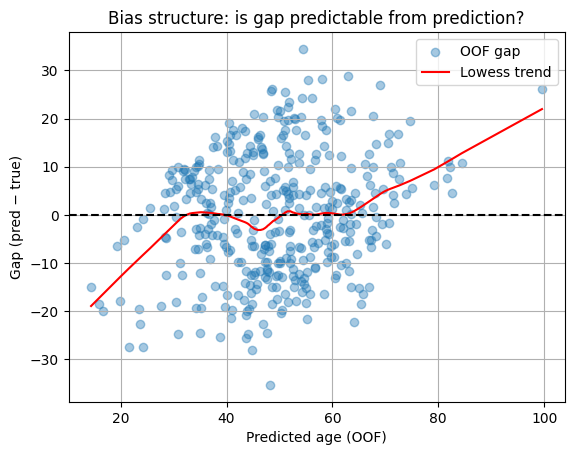

In [32]:
# We plot a smooth curve to understand the relationship between
# - The predicted ages `oof_pred`
# - The error with the true age
smoothed = lowess(gap_oof, oof_pred, frac=0.3)  # adjust frac for more/less smoothing

plt.figure()
plt.scatter(oof_pred, gap_oof, alpha=0.4, label="OOF gap")
plt.plot(smoothed[:,0], smoothed[:,1], 'r-', label="Lowess trend")
plt.axhline(0, linestyle='--', color='k')
plt.xlabel("Predicted age (OOF)")
plt.ylabel("Gap (pred − true)")
plt.title("Bias structure: is gap predictable from prediction?")
plt.legend()
plt.grid(True)
plt.show()

We see that the curve is flat, with a little wiggle. Most likely it's noise, so it means we can't exploit any bias for our data.
That's what happening: we are adding noise with the correction, and the prediction fails!

At this point, let's try to improve the model by a different approach.
The cortical thickness may not capture the true age relationship due to covariates (sex, site, scanner). Let's include them

In [33]:
covariates_labels = ["sex", "site", "scanner"]

In [34]:
X_all_df = train_set[labels_features + covariates_labels].fillna("missing")
X_all_df.head(3)

,lh_caudalanteriorcingulate,lh_caudalmiddlefrontal,lh_cuneus,lh_entorhinal,lh_fusiform,lh_inferiorparietal,lh_inferiortemporal,lh_insula,lh_isthmuscingulate,lh_lateraloccipital,...,rh_rostralanteriorcingulate,rh_rostralmiddlefrontal,rh_superiorfrontal,rh_superiorparietal,rh_superiortemporal,rh_supramarginal,rh_transversetemporal,sex,site,scanner
0,2.767575,2.828643,2.019888,2.712761,2.841887,2.487441,3.102358,3.180834,2.489012,2.139495,...,2.899147,2.635482,3.117611,2.317504,3.213092,2.725745,2.460538,Female,Guy’s-Hospital,Philips-1.5T
1,2.400216,2.533996,1.716370,3.097469,2.224258,2.323388,2.750064,3.022653,2.081978,1.909471,...,2.652905,2.352631,2.635217,2.109884,2.871431,2.485718,2.019534,Male,Hammersmith-Hospital,Philips-3.0T
2,2.520548,2.499412,1.458557,2.951624,2.219040,2.405152,2.770652,3.022749,2.035213,1.790117,...,2.655105,2.347103,2.558824,2.037381,2.887120,2.578263,1.791700,Male,Hammersmith-Hospital,Philips-3.0T


We can easily manipulate pandas like feature with processors in sklearn

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), labels_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), covariates_labels),
    ],
    remainder="drop",
)

# Define the model
model = Pipeline([
    ("preproc", preprocessor),
    ("reg", LinearRegression())
])

In [36]:
X_tr_all_df = X_all_df.iloc[tr_idx]
X_te_all_df = X_all_df.iloc[te_idx]

Naive linear regression MAE: 9.797 +/- 6.368, R²: 0.519
Mean brain age gap (pred − true): 0.313


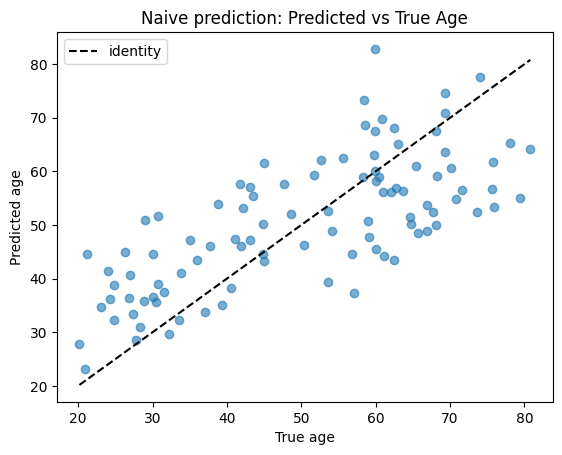

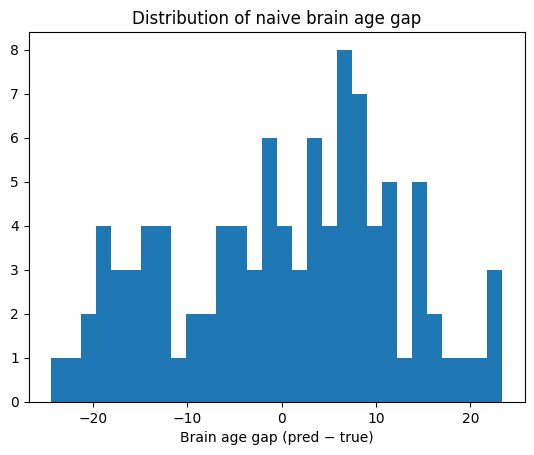

In [41]:
model.fit(X_tr_all_df, y_tr)
y_pred = model.predict(X_te_all_df)

mae_m, mae_std = mae_fn(y_te, y_pred)
r2 = r2_score(y_te, y_pred)
print(f"Naive linear regression MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

# Brain age gap
gap = y_pred - y_te
print(f"Mean brain age gap (pred − true): {np.mean(gap):.3f}")

# Plot
plt.figure()
plt.scatter(y_te, y_pred, alpha=0.6)
plt.plot([y_te.min(), y_te.max()],
         [y_te.min(), y_te.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title("Naive prediction: Predicted vs True Age")
plt.legend()
plt.show()

plt.figure()
plt.hist(gap, bins=30)
plt.xlabel("Brain age gap (pred − true)")
plt.title("Distribution of naive brain age gap")
plt.show()

We slightly improve the model! Very good news. Except... we still have the same issue!
Could be that... maybe site and scanners are not that useful? Let's investigate.

Exercise:

Develop a way to investigate this problem without training a new model. Can you think of any useful way?

When we include the scanner, the following may happen
- we have less representative scanners (remember eda... this is true)
- scanners may be linked to the age in a non trivial way (in a specific scanner we only scanned people in a certain age range)

Let's try to test all the models at the same time to clearly see this effect. This time, we try to account for some variance by using kfolding

In [93]:
# let's write a little function that allows us to test quickly various model
def evaluate_models_with_cv(df: pd.DataFrame,
                            labels_features,
                            include_scanner=False,
                            include_sex=False,
                            model_reg=None,
                            n_splits=5,
                            random_state=0,):
    if model_reg is None:
        model_reg = LinearRegression()

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    transformers = [("num", StandardScaler(), labels_features)]
    if covariates: # only if we have covariates we append
        transformers.append(
            ("cat", OneHotEncoder(drop="first", sparse_output=False), covariates)
        )

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    model = Pipeline([
        ("preproc", preprocessor),
        ("reg", model_reg)
    ])

    X: pd.DataFrame = df[labels_features + covariates]
    y = df["age"].values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    preds = np.zeros(len(y))

    for train_idx, val_idx in kf.split(np.arange(len(X))):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)
        preds[val_idx] = m.predict(X_val)

    return {
        "r2": r2_score(y, preds),
        "mae": mean_absolute_error(y, preds),
        "preds": preds,
        "fitted_whole_model": clone(model).fit(X, y)
    }

# Evaluate
res_base = evaluate_models_with_cv(train_set, labels_features, include_scanner=False)
res_scanner = evaluate_models_with_cv(train_set, labels_features, include_scanner=True)
res_sex = evaluate_models_with_cv(train_set, labels_features, include_sex=True)
res_both = evaluate_models_with_cv(train_set, labels_features, include_scanner=True, include_sex=True)

print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])

Thickness only R²: 0.4491875502599263 MAE: 9.921819442366983
Thickness + scanner R²: 0.4488638770709876 MAE: 9.93409176566096
Thickness + sex R²: 0.4618442282501902 MAE: 9.761747304804048
Thickness + scanner + sex R²: 0.4624454868247121 MAE: 9.779456827372549


We discovered that the model with the scanner included is on par with the sex one, which confirms our hypotesis!
This also removes a problem we would have in test. The scanner is unknown, and thus it would be not possible to use our model on test set:

In [ ]:
whole_model = res_both["fitted_whole_model"]
y_test_pred = whole_model.predict(test_set)

So we can only use the sex one, unless we rely on mixed models that allow to learn the scanner effects as random effects / account for scanner residuals.

In [95]:
whole_model = res_sex["fitted_whole_model"]
y_test_pred = whole_model.predict(test_set)

Naive linear regression MAE: 14.273, R²: -0.132
Mean brain age gap (pred − true): 10.866


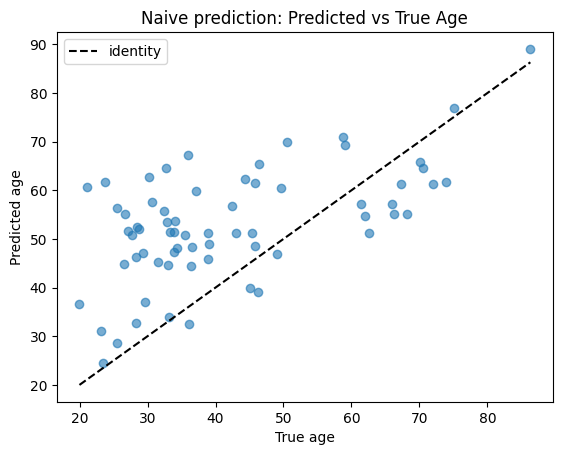

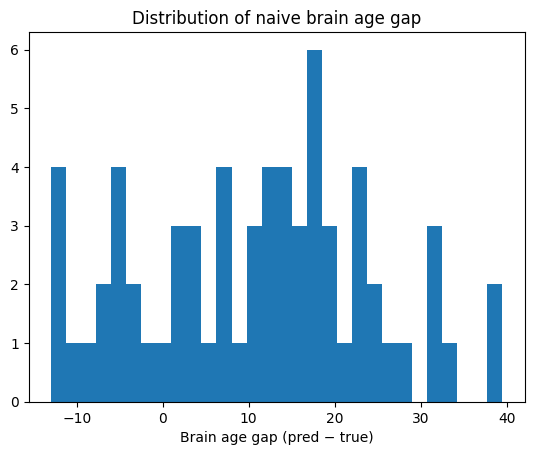

In [ ]:
# And evaluate.
mae_m, mae_std = mae_fn(y_test_set.reshape(-1,1), y_test_pred.reshape(-1,1))
r2 = r2_score(y_test_set, y_test_pred)
print(f"Naive linear regression MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

# Brain age gap
gap = y_test_pred - y_test_set
print(f"Mean brain age gap (pred − true): {np.mean(gap):.3f}")

# Plot
plt.figure()
plt.scatter(y_test_set, y_test_pred, alpha=0.6)
plt.plot([y_test_set.min(), y_test_set.max()],
         [y_test_set.min(), y_test_set.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title("Naive prediction: Predicted vs True Age")
plt.legend()
plt.show()

plt.figure()
plt.hist(gap, bins=30)
plt.xlabel("Brain age gap (pred − true)")
plt.title("Distribution of naive brain age gap")
plt.show()

However, as we can see, on the test set we still have an huge problem! Can we try better approaches?
Let's try to understand if this is possibly related to a scanner shift. One of the most well known technique to take this kind of scanner shifts effect in consideration is harmonization.
ComBat is one of the most known technique for this

In [ ]:
# Directly extract thickness
X_tr_thick = train_set.iloc[tr_idx][labels_features].values
X_val_thick = train_set.iloc[te_idx][labels_features].values
X_test_thick = test_set[labels_features].values

# We need to format properly for combat
def prepare_covars(df):
    cov = pd.DataFrame({
        "SITE": df["scanner"].astype(str),
        "SEX": df["sex"].map({"Male": 1, "Female": 0}) if df["sex"].dtype == object else df["sex"].astype(float),
        "AGE": df["age"].astype(float)
    })
    return cov

covars_train = prepare_covars(train_set.iloc[tr_idx])
covars_val = prepare_covars(train_set.iloc[te_idx])
covars_test = prepare_covars(test_set)

# We slightly clip the ages to account for the fact that we have a discrepancy in age range covered from test set, but it's negligeable.
age_min = covars_train["AGE"].min()
age_max = covars_train["AGE"].max()

# small epsilon to avoid exact boundary issues
eps = 1e-6
covars_val_adj = covars_val.copy()
covars_test_adj = covars_test.copy()
covars_val_adj["AGE"] = covars_val_adj["AGE"].clip(lower=age_min + eps, upper=age_max - eps)
covars_test_adj["AGE"] = covars_test_adj["AGE"].clip(lower=age_min + eps, upper=age_max - eps)

# Via smooth_terms, we specify the variables which can model non-linear effects with the input variables (cortical thickness)
smooth_terms = ["AGE"] 

model, X_tr_combat = harmonizationLearn(
    X_tr_thick,
    covars_train,
    eb=True,
    # smooth_terms=smooth_terms,
    return_s_data=False
)

And now we use this normalized features.

In [ ]:
def evaluate_models_with_combat(df: pd.DataFrame,
                                train_idx,
                                val_idx,
                                labels_features,
                                include_scanner=False,
                                include_sex=False,
                                model_reg=None,):
    internal_df = df.copy()
    internal_df["age_bin"] = pd.cut(internal_df["age"], bins=10, labels=False, include_lowest=True)
    internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)

    if model_reg is None:
        model_reg = LinearRegression()

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    transformers = [("num", StandardScaler(), labels_features)]
    if covariates:
        # Use sparse=False for broader sklearn compatibility
        transformers.append(("cat", OneHotEncoder(drop="first", sparse_output=False), covariates))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    model = Pipeline([
        ("preproc", preprocessor),
        ("reg", model_reg)
    ])

    # Split X/y
    X: pd.DataFrame = internal_df[labels_features + covariates]
    y = internal_df["age"].values
    X_tr = X.iloc[train_idx].copy()
    X_val = X.iloc[val_idx].copy()
    y_tr = y[train_idx]
    y_val = y[val_idx]

    X_train_thick = X_tr[labels_features].to_numpy()
    X_val_thick   = X_val[labels_features].to_numpy()

    def _prep_cov(index):
        sex_series = internal_df.loc[index, "sex"]
        sex_num = sex_series.map({"Male": 1, "Female": 0}) if sex_series.dtype == object else sex_series.astype(float)
        cov = pd.DataFrame({
            "SITE": internal_df.loc[index, "scanner"],
            "SEX":  sex_num.astype(float),
            "AGE":  internal_df.loc[index, "age"].astype(float),
        }, index=index)
        return cov

    covars_train = _prep_cov(X_tr.index).copy()
    covars_val   = _prep_cov(X_val.index).copy()

    # Harmonization: learn on train, apply to val
    from neuroHarmonize import harmonizationLearn, harmonizationApply

    # Guard: unseen/NaN sites in val → fall back to raw
    train_sites = pd.Categorical(covars_train["SITE"].astype(str)).categories
    covars_train["SITE"] = pd.Categorical(covars_train["SITE"].astype(str), categories=train_sites)
    covars_val["SITE"]   = pd.Categorical(covars_val["SITE"].astype(str),   categories=train_sites)

    # Clip AGE in val to train range (tiny epsilon)
    age_min, age_max = covars_train["AGE"].min(), covars_train["AGE"].max()
    eps = 1e-6
    covars_val["AGE"] = covars_val["AGE"].clip(lower=age_min + eps, upper=age_max - eps)

    try:
        harm_model, X_train_harm = harmonizationLearn(
            X_train_thick, covars_train, eb=True, return_s_data=False
        )
        X_val_harm = harmonizationApply(
            data=X_val_thick, model=harm_model, covars=covars_val
        )
        used_harmonization = True
    except Exception as _:
        # e.g., validation has SITE entirely NaN / unseen → ComBat can't apply
        print("FAILED")
        X_train_harm = X_train_thick
        X_val_harm   = X_val_thick
        used_harmonization = False

    # Replace feature block with harmonized values
    X_tr.loc[:, labels_features] = X_train_harm
    X_val.loc[:, labels_features] = X_val_harm

    # Fit & predict
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    # --- Fit a whole-dataset model on harmonized features (optional) ---
    # Harmonize the FULL dataset to return a fitted model consistent with the fold logic.
    try:
        covars_full = _prep_cov(X.index)
        # Align categories
        full_sites = pd.Categorical(covars_full["SITE"].astype(str)).categories
        covars_full["SITE"] = pd.Categorical(covars_full["SITE"].astype(str), categories=full_sites)
        harm_full, X_full_harm = harmonizationLearn(
            X[labels_features].to_numpy(), covars_full, eb=True, return_s_data=False
        )
        X_full_for_fit = X.copy()
        X_full_for_fit.loc[:, labels_features] = X_full_harm
        fitted_whole_model = clone(model).fit(X_full_for_fit, y)
    except Exception:
        # Fall back to unharmonized full fit if something goes wrong
        fitted_whole_model = clone(model).fit(X, y)

    return {
        "r2": r2_score(y_val, preds),
        "mae": mean_absolute_error(y_val, preds),
        "preds": pd.Series(preds, index=X_val.index),  # align to val_idx
        "used_harmonization": used_harmonization,
        "fitted_whole_model": fitted_whole_model
    }

/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Thickness only R²: 0.45889578266795794 MAE: 9.895158889472794
Thickness + scanner R²: 0.4592264701573857 MAE: 9.887848792478994
Thickness + sex R²: 0.4669588757596762 MAE: 9.802206599919712
Thickness + scanner + sex R²: 0.4702293531613164 MAE: 9.812196979384533


Even using combat and learn an invariant version doesn't help with the prediction. Probably we don't have sufficient data for combat.
Before wrapping up the lesson with non-linear models, I would like to introduce an additional way to deal with this error in prediction
Recent research shown that a Correlation Constrained Ridge Regression may help with keeping the bias in check (https://www.frontiersin.org/journals/psychiatry/articles/10.3389/fpsyt.2021.615754/full)

Let's try to implement it

In [ ]:
def age_delta_correlation(y_true, y_pred):
    # delta = predicted - true; ADC = corr(true, delta)
    delta = y_pred - y_true
    if np.std(delta) == 0 or np.std(y_true) == 0:
        return 0.0
    return np.corrcoef(y_true, delta)[0, 1]

class CorrelationConstrainedKernelRidge(BaseEstimator, RegressorMixin):
    """
    Kernel Ridge with an explicit bound on the age-delta correlation (ADC).
    Implements the analytic bounded-correlation solution from Treder et al. 2021.
    If |ADC| <= rho, keeps the unconstrained solution. Otherwise rescales the
    predictions by a factor theta so that |ADC| == rho with the same sign.
    """
    def __init__(self, alpha=1.0, kernel='rbf', gamma=None, rho=0.0):
        self.alpha = alpha  # regularization
        self.kernel = kernel
        self.gamma = gamma
        self.rho = rho  # allowed absolute age-delta correlation (ρ in paper)

    def fit(self, X, y):
        # fit a kernel ridge (ridge regression based on kernels, for instant the rbf)
        self.krr_ = KernelRidge(alpha=self.alpha, kernel=self.kernel, gamma=self.gamma)
        self.krr_.fit(X, y)

        # We get a "age" prediction
        y_hat = self.krr_.predict(X) 

        # We ge the correlation between the original age and the predicted age
        adc = age_delta_correlation(y, y_hat)

        if abs(adc) <= self.rho:
            # No constraint violated: keep original dual coefficients
            # the dual coefficients are the coefficients of the ridge regression that weights the kernel terms 
            self.dual_coef_ = self.krr_.dual_coef_.copy()
            self._theta = 1.0

        else:
            # We need to find a dual coefficient scaler such that
            # corr(y, delta_cc) = sign(adc)*rho
            # where: delta_cc = y_hat_cc - y = contrained_model(X) - y

            # We'll search the two analytic roots from Treder et al. and pick the one
            # that achieves the desired sign and magnitude.
            y_vec = y.reshape(-1)
            y_hat_vec = y_hat.reshape(-1)
            # Define quantities
            norm_y2 = np.dot(y_vec, y_vec)  # ||y||^2
            norm_yhat2 = np.dot(y_hat_vec, y_hat_vec)  # ||ŷ||^2
            yT_yhat = np.dot(y_vec, y_hat_vec)  # y^T ŷ
            target_adc = np.sign(adc) * self.rho

            # The idea is to solve the optimization problem of corr(y, delta_cc) = sign(adc)*rho
            # And you can express it as corr(y, e_cc) = -corr(y, delta_cc)
            # where e = y - ŷ = -delta

            rho_e = abs(target_adc)  # magnitude for their formula
            c = (yT_yhat ** 2) - (rho_e ** 2) * norm_y2 * norm_yhat2
            # If c is zero or numerically problematic, fall back to no scaling
            
            if np.isclose(c, 0):
                self.dual_coef_ = self.krr_.dual_coef_.copy()
                self._theta = 1.0

            else:
                # We use the analitical solution from the paper
                term1 = norm_y2 * yT_yhat * (1 - rho_e ** 2) / c

                inside_sqrt = rho_e ** 2 * (1 - rho_e ** 2) * (norm_y2 * norm_yhat2 - yT_yhat ** 2)
                if inside_sqrt < 0:
                    # numerical issues; clamp to zero
                    inside_sqrt = 0.0

                # This can be both positive or negative
                term2 = (norm_y2 / abs(c)) * np.sqrt(inside_sqrt)
                # so we have to solutions
                theta_candidates = [term1 + term2, term1 - term2]

                # We evaluate which candidate gives desired ADC (within tolerance)
                best_theta = None
                best_diff = np.inf
                for theta in theta_candidates:
                    y_hat_cc = theta * y_hat_vec
                    adc_cc = age_delta_correlation(y_vec, y_hat_cc)
                    # We want |adc_cc| close to |target_adc| and sign matching
                    if np.sign(adc_cc) != np.sign(target_adc):
                        continue
                    diff = abs(abs(adc_cc) - abs(target_adc))
                    if diff < best_diff:
                        best_diff = diff
                        best_theta = theta
                        
                if best_theta is None:
                    # fallback: choose theta that minimizes squared difference to target
                    # even if sign mismatches
                    best_theta = min(theta_candidates, key=lambda th: abs(abs(age_delta_correlation(y_vec, th * y_hat_vec)) - abs(target_adc)))
                self._theta = best_theta
                # Scale dual coefficients
                self.dual_coef_ = self.krr_.dual_coef_ * self._theta

        # Store training data needed for prediction (KernelRidge keeps theirs internally)
        self.X_fit_ = X
        self.y_fit_ = y
        return self

    def predict(self, X):
        check_is_fitted(self, "dual_coef_")
        # Use underlying kernel evaluation, but with possibly scaled dual coefficients
        # Reproduce prediction logic of KernelRidge: K(X, X_fit_) @ dual_coef_
        from sklearn.metrics.pairwise import pairwise_kernels
        K = pairwise_kernels(
            X,
            self.X_fit_,
            metric=self.kernel,
            filter_params=True,
            **({"gamma": self.gamma} if self.gamma is not None else {})
        )
        return K.dot(self.dual_coef_)

In [70]:
def evaluate_models_with_cv_and_stratified_and_tune(df: pd.DataFrame,
                                            labels_features,
                                            include_scanner=False,
                                            include_sex=False,
                                            model_reg=None,
                                            n_splits=5,
                                            random_state=0,
                                            param_grid = None):
    # Add age_bin
    internal_df = df.copy()
    internal_df["age_bin"] = pd.cut(df["age"], bins=10, labels=False, include_lowest=True)
    internal_df["stratify_key"] = internal_df["age_bin"].astype(str) + "_" + internal_df["sex"].astype(str)
    
    if model_reg is None:
        model_reg = LinearRegression()

    covariates = []
    if include_scanner:
        covariates.append("scanner")
    if include_sex:
        covariates.append("sex")

    transformers = [("num", StandardScaler(), labels_features)]
    if covariates: # only if we have covariates we append
        transformers.append(
            ("cat", OneHotEncoder(drop="first", sparse_output=False), covariates)
        )

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    pipeline = Pipeline([
        ("preproc", preprocessor),
        ("reg", model_reg)
    ])

    X: pd.DataFrame = internal_df[labels_features + covariates]
    y = internal_df["age"].values

    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    preds = np.zeros(len(y))

    eff_model = pipeline
    splits = list(outer_cv.split(np.arange(len(X)), internal_df["stratify_key"].values))

    if param_grid is not None:
        # Cv is used for estimating the best parameter for the model
        search = GridSearchCV(
            estimator=clone(pipeline),
            param_grid=param_grid,
            cv=splits,
            scoring="neg_mean_absolute_error",
            refit=True,
            n_jobs=1,
        )
        search.fit(X, y)
        eff_model = search.best_estimator_

    # We fit the (maybe best) model on the splits
    for (train_idx, val_idx) in splits:
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_tr = y[train_idx]
        y_val = y[val_idx]
        
        m = clone(eff_model)
        m.fit(X_tr, y_tr) # Refit
        preds[val_idx] = m.predict(X_val)

    return {
        "r2": r2_score(y, preds),
        "mae": mean_absolute_error(y, preds),
        "preds": preds,
        "fitted_whole_model": clone(eff_model).fit(X, y)
    }

In [106]:
# We will try it
PARAM_GRID = {
    "reg__alpha": [0.01, 0.1, 1.0],
    "reg__gamma": [0.01, 0.1, 1.0],
    "reg__rho": [0.0, 0.01, 0.05, 0.1],
}

res_base = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=False, model_reg=CorrelationConstrainedKernelRidge(alpha=1.0, kernel="rbf"), param_grid=PARAM_GRID)
res_scanner = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, model_reg=CorrelationConstrainedKernelRidge(alpha=1.0, kernel="rbf"), param_grid=PARAM_GRID)
res_sex = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_sex=True, model_reg=CorrelationConstrainedKernelRidge(alpha=1.0, kernel="rbf"), param_grid=PARAM_GRID)
res_both = evaluate_models_with_cv_and_stratified_and_tune(train_set, labels_features, include_scanner=True, include_sex=True, model_reg=CorrelationConstrainedKernelRidge(alpha=1.0, kernel="rbf"), param_grid=PARAM_GRID)

print("Thickness only R²:", res_base["r2"], "MAE:", res_base["mae"])
print("Thickness + scanner R²:", res_scanner["r2"], "MAE:", res_scanner["mae"])
print("Thickness + sex R²:", res_sex["r2"], "MAE:", res_sex["mae"])
print("Thickness + scanner + sex R²:", res_both["r2"], "MAE:", res_both["mae"])

/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/afrotscher/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Thickness only R²: 0.2953745866574553 MAE: 10.945649826564885
Thickness + scanner R²: 0.2950984775824169 MAE: 10.922368137102254
Thickness + sex R²: 0.3125360799041602 MAE: 10.807633698096136
Thickness + scanner + sex R²: 0.3130412585210389 MAE: 10.789246228778229


In [107]:
whole_model = res_sex["fitted_whole_model"]
y_test_pred = whole_model.predict(test_set)

Naive linear regression MAE: 12.842, R²: -0.056
Mean brain age gap (pred − true): 0.075


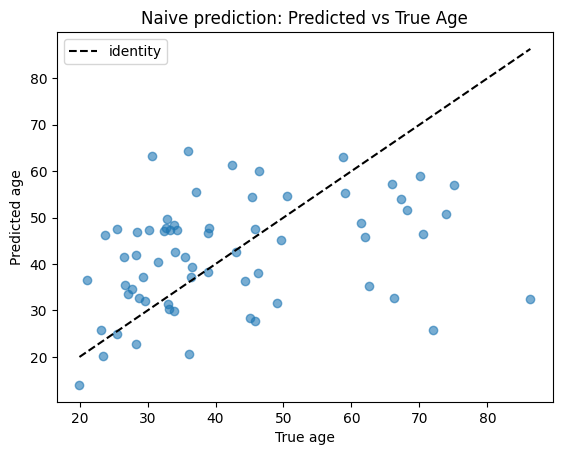

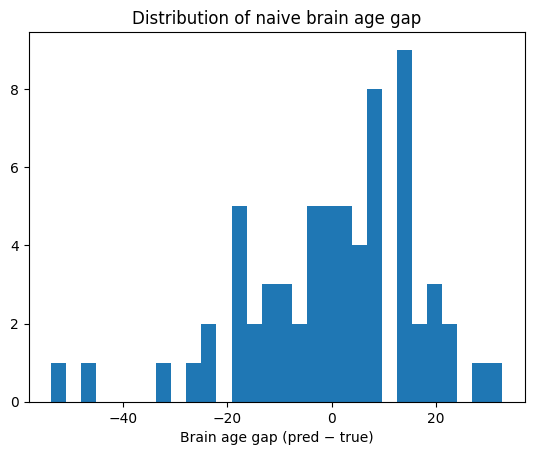

In [ ]:
# And evaluate.
mae_m, mae_std = mae_fn(y_test_set.reshape(-1, 1), y_test_pred.reshape(-1,1))
r2 = r2_score(y_test_set, y_test_pred)
print(f"Naive linear regression MAE: {mae_m:.3f} +/- {mae_std:.3f}, R²: {r2:.3f}")

# Brain age gap
gap = y_test_pred - y_test_set
print(f"Mean brain age gap (pred − true): {np.mean(gap):.3f}")

# Plot
plt.figure()
plt.scatter(y_test_set, y_test_pred, alpha=0.6)
plt.plot([y_test_set.min(), y_test_set.max()],
         [y_test_set.min(), y_test_set.max()], 'k--', label='identity')
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title("Naive prediction: Predicted vs True Age")
plt.legend()
plt.show()

plt.figure()
plt.hist(gap, bins=30)
plt.xlabel("Brain age gap (pred − true)")
plt.title("Distribution of naive brain age gap")
plt.show()

At this point we can evaluate other type of possible regressors

We can try:
- RandomForest
- KernelRidge
- ElasticNetCV

Implement using the methods these models and test them on the test set. What do you notice?